**ATTENTION**

**NEED TO REVIEW FINE-TUNNING**

It is better to consider notebooks made for all pre-trained models, i.e., the ones starting as "Transfer_learning_"

In this notebook we use the pre-trained VGG16 model from keras (https://keras.io/applications/).

Here we will use both possible ways of using a pre-trained NN:`feature extraction` and `fine-tunning`.

`Feature extraction` consists in using the representations learned in a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

In this case, we will be using NN architecture trained on the ImageNet to extract features from images used to detect smoke (fire break).

In the case of `Feature extraction` two approaches are used:

1. `Feature extraction without data augmentation`: This is the cheaper way. We run the convolutional base on the dataset and record its output to a numpy array on disk which is used as input to a stand alone densely connected classifier.

2. `Feature extraction with data augmentation`: Extend the pre-trained model (conv_base) by adding dense layers on top, and running the whole thing end to end. This method is computationaly more expensive but allow us to apply data augmentation.

In the `Fine-tunning method` few of the top layers of a frozen model base used for feature extraction are unfrozen, and both the newly added part of the model are jointly trained.

In addition, when training some of the models we used `class_weight = auto` since our dataset is imbalanced.


In [1]:
image_height = 128
image_width = 128
image_channels = 3
input_shape = (image_height, image_width, image_channels)

In [2]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-12-15 07:26:19.696043


Intantiating the VGG16. Because the densely connected classifier corresponds to the 1,000 classes from ImageNet, and our classifier just need to detect `smoke` and `no smoke`, we set include_top as False. 

`input_shape` is optional since if you don’t pass it, the network will be able to process inputs of any size.

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=input_shape)

Using TensorFlow backend.


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [5]:
conv_base.output_shape

(None, 4, 4, 512)

# Feature Extraction

## Feature Extraction Without Data Augmentation

Running the convolutional base over your dataset, recording its output to a
Numpy array on disk, and then using this data as input to a standalone, densely
connected classifier similar to those you saw in part 1 of this book. This solution
is fast and cheap to run, because it only requires running the convolutional
base once for every input image, and the convolutional base is by far the most
expensive part of the pipeline. But for the same reason, this technique won’t
allow you to use data augmentation.

In [6]:
import os

def count_files_in_directory(path):
    
    fileslist = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            fileslist.append(filename)
            
    return len(fileslist)

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

files_train = count_files_in_directory(train_dir)
files_validation = count_files_in_directory(validation_dir)
files_test = count_files_in_directory(test_dir)


datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3]))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, files_train)
validation_features, validation_labels = extract_features(validation_dir, files_validation)
test_features, test_labels = extract_features(test_dir, files_test)

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [8]:
train_features.shape

(5061, 4, 4, 512)

In [9]:
input_dim = train_features.shape[1] * train_features.shape[2] * train_features.shape[3]

In [10]:
# flatten the samples to enter the densely-connected classifier

train_features = np.reshape(train_features, (files_train, input_dim))
validation_features = np.reshape(validation_features, (files_validation, input_dim))
test_features = np.reshape(test_features, (files_test, input_dim))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 5061 samples, validate on 632 samples
Epoch 1/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.5621 - acc: 0.7495 - val_loss: 0.4993 - val_acc: 0.7864
Epoch 2/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.5085 - acc: 0.7785 - val_loss: 0.4846 - val_acc: 0.7880
Epoch 3/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.4864 - acc: 0.7908 - val_loss: 0.4919 - val_acc: 0.7896
Epoch 4/30
5061/5061 [==============================] - 7s 1ms/step - loss: 0.4713 - acc: 0.7923 - val_loss: 0.4779 - val_acc: 0.7927
Epoch 5/30
5061/5061 [==============================] - 8s 1ms/step - loss: 0.4637 - acc: 0.8004 - val_loss: 0.4694 - val_acc: 0.7975
Epoch 6/30
5061/5061 [==============================] - 8s 1ms/step - loss: 0.4567 - acc: 0.8042 - val_loss: 0.4667 - val_acc: 0.8149
Epoch 7/30
5061/5061 [==============================] - 8s 1ms/step - loss: 0.4508 - acc: 0.8060 - val_loss: 0.4637 - val_acc: 0.8022
Epoch 8/30
5061

In [12]:
model.save("../models/VGG16_model_omdena.h5")

In [13]:
def smooth_curve(points, factor=0.8):
    """ Make curves smoother"""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

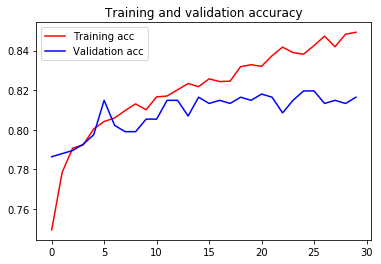

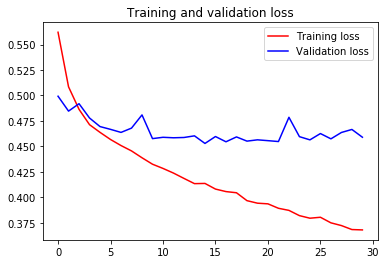

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

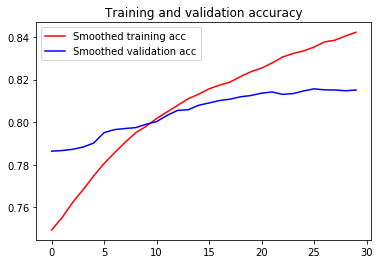

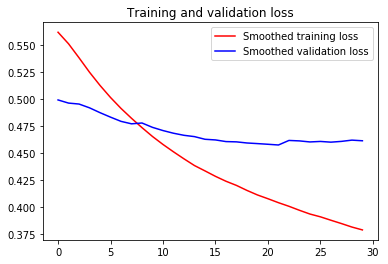

In [15]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../history/VGG16_model_omdena_history.csv", index = False)

In [17]:
t2 = datetime.datetime.now()
(print(t2))
print(t2-t1)

2019-12-15 07:44:54.103929
0:18:34.407886


## Feature Extraction With Data Augmentation

In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [21]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [22]:
conv_base.trainable = False

In [23]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to image_height x image_width
        target_size=(image_height, image_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_height, image_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history2 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 447s - loss: 0.5448 - acc: 0.7532 - val_loss: 0.7420 - val_acc: 0.7712
Epoch 2/30
 - 445s - loss: 0.5154 - acc: 0.7770 - val_loss: 0.5749 - val_acc: 0.7886
Epoch 3/30
 - 437s - loss: 0.5065 - acc: 0.7850 - val_loss: 0.4964 - val_acc: 0.7873
Epoch 4/30
 - 436s - loss: 0.5010 - acc: 0.7855 - val_loss: 0.7227 - val_acc: 0.7724
Epoch 5/30
 - 424s - loss: 0.5054 - acc: 0.7855 - val_loss: 0.5519 - val_acc: 0.7903
Epoch 6/30
 - 463s - loss: 0.4829 - acc: 0.7905 - val_loss: 0.4149 - val_acc: 0.7947
Epoch 7/30
 - 440s - loss: 0.4943 - acc: 0.7895 - val_loss: 0.5218 - val_acc: 0.7853
Epoch 8/30
 - 417s - loss: 0.5094 - acc: 0.7759 - val_loss: 0.3581 - val_acc: 0.7886
Epoch 9/30
 - 448s - loss: 0.4795 - acc: 0.7940 - val_loss: 0.6476 - val_acc: 0.7856
Epoch 10/30
 - 479s - loss: 0.4960 - acc: 0.7810 - val_loss: 0.4836 - val_acc: 0.7954
Epoch 11/30
 - 442s - loss: 0.4745 - acc: 0.7991 - val_loss: 0.6153 - val_acc: 0.7866
Epoch 12/30
 - 462s - loss: 0.4900 - acc: 0.7910 - val_loss: 0.

In [26]:
os.getcwd()

'C:\\PROJECTS_2019\\project_omdena_firebreak_detection_REVIEW\\notebooks'

In [27]:
model.save("../models/VGG16_model_omdena_data_augmentation.h5")

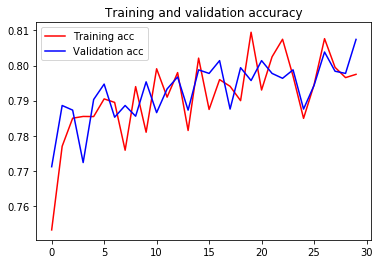

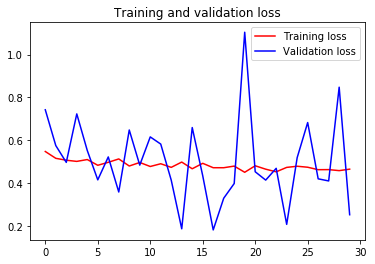

In [28]:
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

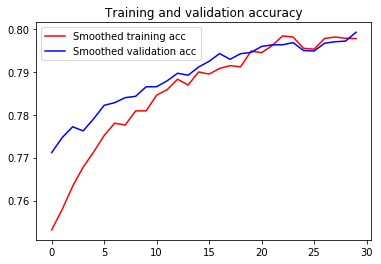

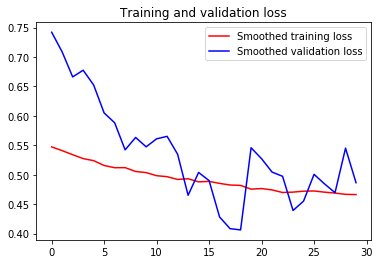

In [29]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
# create a dataframe to save the result as .csv

df = pd.DataFrame(history2.history)

df.to_csv("../history/VGG16_model_omdena_history_data_augmentation.csv", index = False)

In [31]:
t3 = datetime.datetime.now()
print(t3)
print(t3-t2)

2019-12-15 11:40:37.818591
3:55:43.714662


In [32]:
history3 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2,
      class_weight = 'auto')

Epoch 1/30
 - 423s - loss: 0.4607 - acc: 0.8072 - val_loss: 0.3207 - val_acc: 0.8004
Epoch 2/30
 - 425s - loss: 0.4620 - acc: 0.7975 - val_loss: 0.4691 - val_acc: 0.7967
Epoch 3/30
 - 406s - loss: 0.4631 - acc: 0.8062 - val_loss: 0.3935 - val_acc: 0.8044
Epoch 4/30
 - 407s - loss: 0.4649 - acc: 0.7970 - val_loss: 0.3175 - val_acc: 0.8039
Epoch 5/30
 - 410s - loss: 0.4689 - acc: 0.7970 - val_loss: 0.5626 - val_acc: 0.8014
Epoch 6/30
 - 419s - loss: 0.4620 - acc: 0.7960 - val_loss: 0.5569 - val_acc: 0.7917
Epoch 7/30
 - 411s - loss: 0.4549 - acc: 0.8000 - val_loss: 0.2167 - val_acc: 0.8004
Epoch 8/30
 - 409s - loss: 0.4707 - acc: 0.7839 - val_loss: 0.4645 - val_acc: 0.7988
Epoch 9/30
 - 405s - loss: 0.4601 - acc: 0.7996 - val_loss: 0.5513 - val_acc: 0.7947
Epoch 10/30
 - 404s - loss: 0.4476 - acc: 0.8100 - val_loss: 0.7039 - val_acc: 0.7833
Epoch 11/30
 - 409s - loss: 0.4497 - acc: 0.8135 - val_loss: 0.3175 - val_acc: 0.8120
Epoch 12/30
 - 403s - loss: 0.4735 - acc: 0.7960 - val_loss: 0.

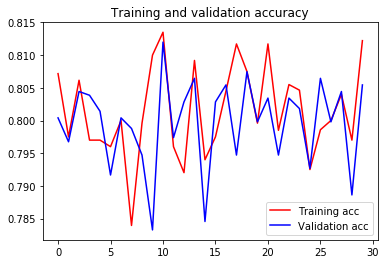

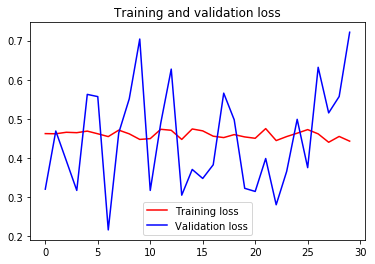

In [33]:
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

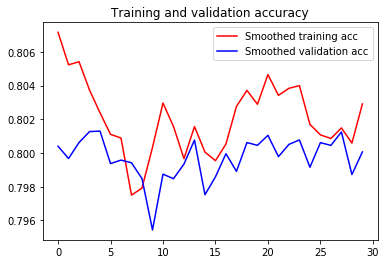

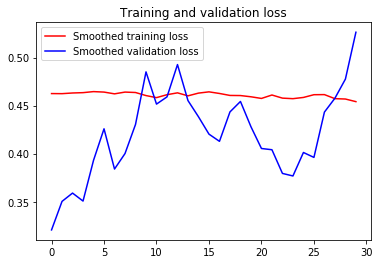

In [34]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# create a dataframe to save the result as .csv

df = pd.DataFrame(history3.history)

df.to_csv("../history/VGG16_model_omdena_history_data_augmentation_weight_auto.csv", index = False)

In [36]:
t4 = datetime.datetime.now()
print(t4)
print(t4-t3)

2019-12-15 15:15:50.700450
3:35:12.881859


# Fine-tunning

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [38]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history4 = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      class_weight = 'auto')

Epoch 1/100
100/100 [==============================] - 471s 5s/step - loss: 0.4918 - acc: 0.7815 - val_loss: 0.3676 - val_acc: 0.8075
Epoch 2/100
100/100 [==============================] - 470s 5s/step - loss: 0.4546 - acc: 0.8046 - val_loss: 0.5266 - val_acc: 0.7846
Epoch 3/100
100/100 [==============================] - 473s 5s/step - loss: 0.4201 - acc: 0.8235 - val_loss: 0.5637 - val_acc: 0.8014
Epoch 4/100
100/100 [==============================] - 470s 5s/step - loss: 0.4550 - acc: 0.7986 - val_loss: 0.2261 - val_acc: 0.8028
Epoch 5/100
100/100 [==============================] - 517s 5s/step - loss: 0.4651 - acc: 0.7960 - val_loss: 0.3952 - val_acc: 0.8024
Epoch 6/100
100/100 [==============================] - 550s 6s/step - loss: 0.4350 - acc: 0.8150 - val_loss: 0.4242 - val_acc: 0.8171
Epoch 7/100
100/100 [==============================] - 491s 5s/step - loss: 0.4390 - acc: 0.8067 - val_loss: 0.7106 - val_acc: 0.7974
Epoch 8/100
100/100 [==============================] - 481s 5s

Epoch 62/100
100/100 [==============================] - 472s 5s/step - loss: 0.3676 - acc: 0.8420 - val_loss: 0.4755 - val_acc: 0.8105
Epoch 63/100
100/100 [==============================] - 470s 5s/step - loss: 0.3437 - acc: 0.8582 - val_loss: 0.6106 - val_acc: 0.7988
Epoch 64/100
100/100 [==============================] - 469s 5s/step - loss: 0.3437 - acc: 0.8495 - val_loss: 0.2078 - val_acc: 0.8059
Epoch 65/100
100/100 [==============================] - 471s 5s/step - loss: 0.3486 - acc: 0.8525 - val_loss: 0.1663 - val_acc: 0.7984
Epoch 66/100
100/100 [==============================] - 465s 5s/step - loss: 0.3524 - acc: 0.8576 - val_loss: 0.4756 - val_acc: 0.8130
Epoch 67/100
100/100 [==============================] - 471s 5s/step - loss: 0.3465 - acc: 0.8551 - val_loss: 0.2824 - val_acc: 0.7843
Epoch 68/100
100/100 [==============================] - 474s 5s/step - loss: 0.3385 - acc: 0.8585 - val_loss: 0.6455 - val_acc: 0.8110
Epoch 69/100
100/100 [==============================] -

In [40]:
model.save("../models/VGG16_model_omdena_data_augmentation_fine_tunned.h5")

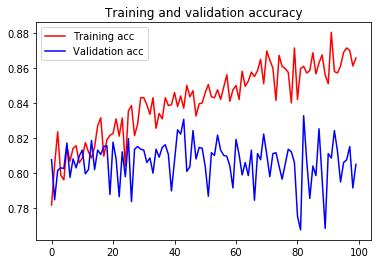

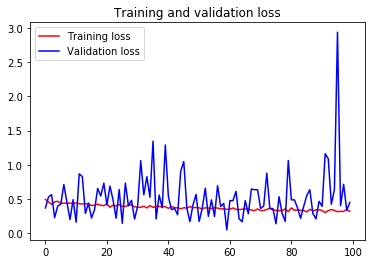

In [41]:
import matplotlib.pyplot as plt

acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

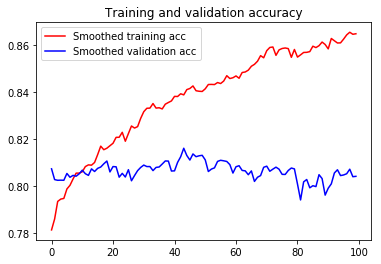

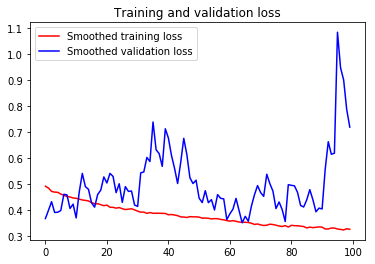

In [42]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
# create a dataframe to save the result as .csv

df = pd.DataFrame(history4.history)

df.to_csv("../history/VGG16_model_omdena_history_data_augmentation_weight_auto_fine_tunned.csv", index = False)

In [44]:
t5 = datetime.datetime.now()
print(t5)
print(t5-t4)

2019-12-16 04:27:40.466073
13:11:49.765623
